### Regression Model with heterogeneous data - mix of categorical and numerical features

Metro Interstate Traffic dataset captures various weather conditions and traffic volume every hour. Below I'll investigate given features and engineer new ones resulting in a mix of categorical and numerical features. First I'll be applying very simple model - Linear Regression and try non-linear Gradient Regression. Since I have mix of categorical and numerical features I'll compare results with Histogram Gradient Boosting Regressor. Based on various research including <a href="https://link.springer.com/chapter/10.1007%2F978-3-030-37334-4_4">"Histogram-Based Algorithm for Building Gradient Boosting Ensembles of Piecewise Linear Decision Trees"</a>, decision tree better suited for categorical variables and by combining it with another regression algorithm it allows to analyze mixed data. Fitted model will be used to build simple web app where user can experiment with various weather and time variables to predict traffic volume. Details of web application implementation can be found in future posts.


**Model Goal**

To predict traffic volume based on weather conditions, time of the day and temperature.

**Data**

Data source is "Metro Interstate Traffic" available through the UCI Machine Learning Repository of the University of California, Irvine. 

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

Dataset consists of 48204 rows and 9 columns. Captured features include:

**holiday** Categorical US National holidays plus regional holiday, Minnesota State Fair
**temp** Numeric Average temp in kelvin
**rain_1h** Numeric Amount in mm of rain that occurred in the hour
**snow_1h** Numeric Amount in mm of snow that occurred in the hour
**clouds_all** Numeric Percentage of cloud cover
**weather_main** Categorical Short textual description of the current weather
**weather_description** Categorical Longer textual description of the current weather
**date_time** DateTime Hour of the data collected in local CST time
**traffic_volume** Numeric Hourly I-94 ATR 301 reported westbound traffic volume

**Conclusion**
After data prep and initial analysis, only 1 feature is resulting feature set is numerical and Linear Regression was greatly under-fitting. Gradient regression was not much of the improvement. Histogram Gradient Boosting Regressor showed best results, but there is still room for improvement.


In [109]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Load dataset file
traffic_data_df_raw=pd.read_csv("../MetroInterstateTraffic/data/Metro_Interstate_Traffic_Volume.csv")


In [110]:
traffic_data_df_raw.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [111]:
traffic_data_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64


Text(0.5, 0.98, 'Traffic Volume')

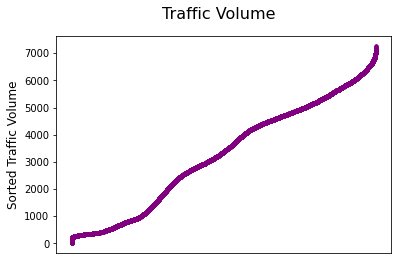

In [112]:
# review of the label feature 'Traffic Volume'

label_feature='traffic_volume'

print(traffic_data_df_raw['traffic_volume'].describe())

fig, ax = plot.subplots(1)
ax.plot(sorted(traffic_data_df_raw['traffic_volume']), color='purple', marker='.')
ax.xaxis.set_visible(False)
ax.set_ylabel("Sorted Traffic Volume", fontsize=12)
fig.suptitle("Traffic Volume", fontsize=16)


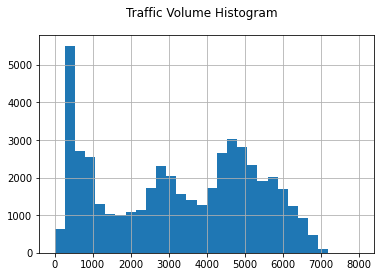

In [113]:
traffic_data_df_raw['traffic_volume'].hist(bins=30, range=(0,8000)).plot()
plot.suptitle('Traffic Volume Histogram')
plot.show()

               temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  48204.000000  48204.000000  48204.000000  48204.000000    48204.000000
mean     281.205870      0.334264      0.000222     49.362231     3259.818355
std       13.338232     44.789133      0.008168     39.015750     1986.860670
min        0.000000      0.000000      0.000000      0.000000        0.000000
25%      272.160000      0.000000      0.000000      1.000000     1193.000000
50%      282.450000      0.000000      0.000000     64.000000     3380.000000
75%      291.806000      0.000000      0.000000     90.000000     4933.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000


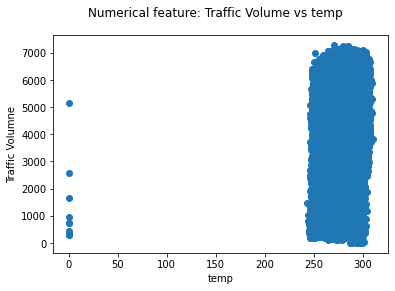

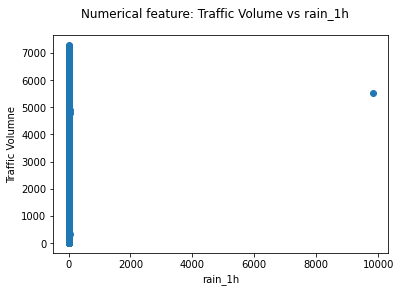

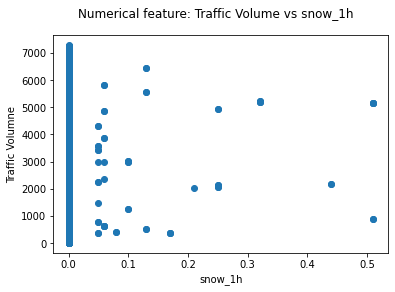

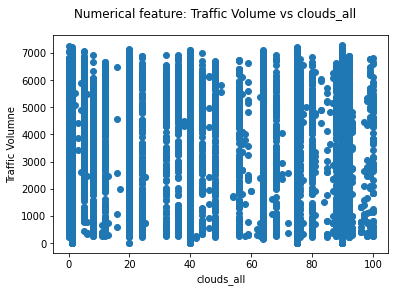

In [114]:
# review of dataset's numerical features

print(traffic_data_df_raw.describe())

traffic_unlabeled_data_df=traffic_data_df_raw.drop(["traffic_volume"], axis=1)

counter_=0

for type_ in traffic_unlabeled_data_df.dtypes:
    if(type_=="float64" or type_=="int64"):
        traffic_plot_data_df=traffic_data_df_raw.sort_values(traffic_data_df_raw.dtypes.index[counter_])
        feature = traffic_data_df_raw.dtypes.index[counter_]
        plot.scatter(traffic_plot_data_df[feature], traffic_plot_data_df['traffic_volume'])
        plot.suptitle("Numerical feature: Traffic Volume vs " + feature)
        plot.xlabel(feature)
        plot.ylabel("Traffic Volumne")
        plot.show()
    counter_+=1

Calculating R-squared for each numerical feature to verify how close the data fits linear regression line. For the simplicity calculating only 1 feature at the time. Additionally could calculate R^2 score for multiple features (not covered here).

In [115]:
from sklearn.metrics import r2_score

traffic_numerical_data_df=traffic_data_df_raw.copy() 

features = [feature for feature in list(traffic_numerical_data_df) if feature not in [label_feature]]

X_train, X_test, y_train, y_test = train_test_split(traffic_numerical_data_df[features], traffic_numerical_data_df[[label_feature]], test_size=0.3, random_state=42)

counter_=0

for type_ in traffic_unlabeled_data_df.dtypes:
    if(type_=="float64" or type_=="int64"):
        feature = traffic_numerical_data_df.dtypes.index[counter_]
        model_lr = linear_model.LinearRegression()
        model_lr.fit(X_train[[feature]], y_train)
        predictions = model_lr.predict(X_test[[feature]])
        print('R^2 for %s is %f' % (feature, r2_score(y_test, predictions)))
    counter_+=1
    

R^2 for temp is 0.019426
R^2 for rain_1h is -0.000005
R^2 for snow_1h is -0.000064
R^2 for clouds_all is 0.004152


Features Rain and Snow were not evenly represented in the data set and their R^2 scores are negative. Clouds feature has positive R^2 score but showed no dependency between traffic volume and cloud percentage on the plot. All 3 features will be dropped from the dataset, leaving only 1 original numerical feature Temperature.

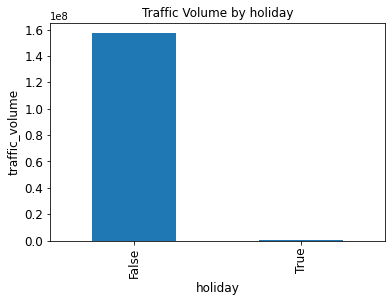

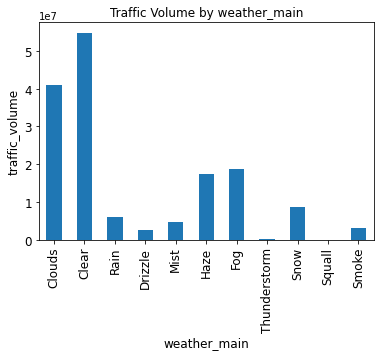

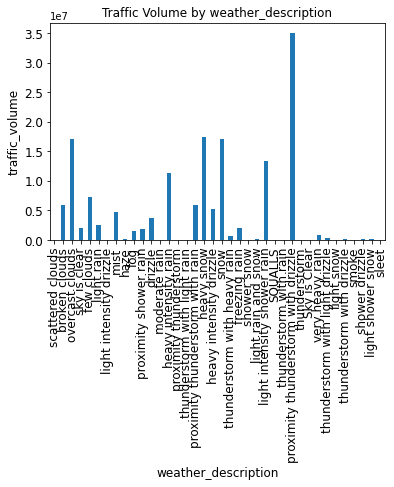

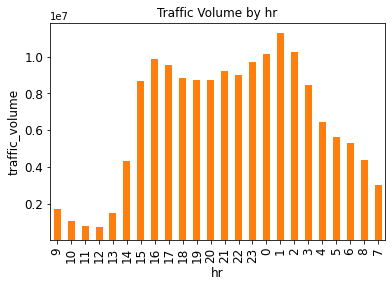

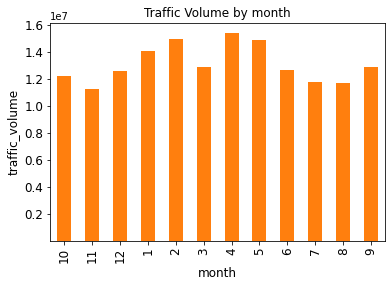

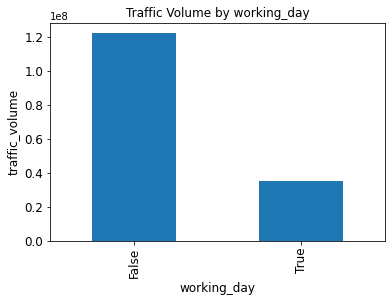

In [116]:
# Dropping features Rain, Snow and Clouds.

traffic_data_df=traffic_data_df_raw.copy()

traffic_data_df=traffic_data_df.drop(["clouds_all"], axis=1)
traffic_data_df=traffic_data_df.drop(["rain_1h"], axis=1)
traffic_data_df=traffic_data_df.drop(["snow_1h"], axis=1)

# Splitting date_time into hr , day of week, month
traffic_data_df['hr']=pd.DatetimeIndex(traffic_data_df['date_time']).hour
traffic_data_df['month']=pd.DatetimeIndex(traffic_data_df['date_time']).month
traffic_data_df['working_day']=pd.DatetimeIndex(traffic_data_df['date_time']).dayofweek>4

traffic_data_df=traffic_data_df.drop(['date_time'], axis=1)

# due to high volume of holiday categories, replace Holiday values with True - holiday, False - no holiday
traffic_data_df['holiday'] = np.where((traffic_data_df.holiday == 'None'),False,traffic_data_df.holiday)
traffic_data_df['holiday'] = np.where((traffic_data_df.holiday != False),True,traffic_data_df.holiday)

# Plot categorical fetaures and their counts vs label feature traffic volume
counter_=0

for type_ in traffic_data_df.dtypes:
    if(type_=="object"):
        feature = traffic_data_df.dtypes.index[counter_]        
        feature_data_grouped=traffic_data_df[[feature,'traffic_volume']].groupby([feature]).sum().reset_index() 
        ax=feature_data_grouped.plot(kind='bar', legend=False, title="Traffic Volume by "+feature,stacked=True, fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.set_xticklabels(traffic_data_df[feature].unique())
        ax.set_ylabel("traffic_volume", fontsize=12)
    counter_+=1

for feature in ['hr','month','working_day']:
    feature_data_df=traffic_data_df[[feature,'traffic_volume']].groupby([feature]).sum().reset_index() 
    ax=feature_data_df.sort_values(feature).plot(kind='bar', legend=False, title="Traffic Volume by "+feature,stacked=True, fontsize=12)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_xticklabels(traffic_data_df[feature].unique())
    ax.set_ylabel("traffic_volume", fontsize=12)
    

Feature Holiday is largely skewed towards non-holiday days and introduces bias for holidays, they are not represented enough to make a judgment on their affect on traffic volume. 

Feature Weather Description broken into too many categories which are not equally represented in dataset and feature Weather Main represents same information in concise manner.


In [117]:
# Dropping features Holiday and Weather Description

traffic_data_df=traffic_data_df.drop(["holiday"], axis=1)
traffic_data_df=traffic_data_df.drop(["weather_description"], axis=1)

traffic_data_df=pd.get_dummies(traffic_data_df, columns=["weather_main", "hr", "month","working_day"], drop_first=False, dummy_na=False)
traffic_data_df=traffic_data_df.dropna()
print(traffic_data_df.info())

# since only 1 numerical feature Temp remained in dataset, it doesn't make sense to use polynomial transform

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48204 entries, 0 to 48203
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   temp                       48204 non-null  float64
 1   traffic_volume             48204 non-null  int64  
 2   weather_main_Clear         48204 non-null  uint8  
 3   weather_main_Clouds        48204 non-null  uint8  
 4   weather_main_Drizzle       48204 non-null  uint8  
 5   weather_main_Fog           48204 non-null  uint8  
 6   weather_main_Haze          48204 non-null  uint8  
 7   weather_main_Mist          48204 non-null  uint8  
 8   weather_main_Rain          48204 non-null  uint8  
 9   weather_main_Smoke         48204 non-null  uint8  
 10  weather_main_Snow          48204 non-null  uint8  
 11  weather_main_Squall        48204 non-null  uint8  
 12  weather_main_Thunderstorm  48204 non-null  uint8  
 13  hr_0                       48204 non-null  uin

**Linear Regression**

In [118]:
traffic_lr_data_df=traffic_data_df.copy()

features = [feature for feature in list(traffic_lr_data_df) if feature not in [label_feature]]

x_lr_train, x_lr_test, y_lr_train, y_lr_test = train_test_split(traffic_lr_data_df[features], traffic_lr_data_df[[label_feature]], test_size=0.3, random_state=42)

lr_model=linear_model.LinearRegression()
lr_model.fit(x_lr_train, y_lr_train)

predictions_lr=lr_model.predict(x_lr_test)
print("Linear Model - Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_lr_test, predictions_lr)))



Linear Model - Root Mean squared error: 826.15


**Gradient Boosting Regressor**

In [119]:
# trying non-linear model
traffic_gbr_data_df=traffic_data_df.copy()

features_grb = [feature for feature in list(traffic_gbr_data_df) if feature not in [label_feature]]

x_grb_train, x_grb_test, y_grb_train, y_grb_test = train_test_split(traffic_gbr_data_df[features_grb], traffic_gbr_data_df[[label_feature]], test_size=0.3, random_state=42)

model_gbr = GradientBoostingRegressor()
model_gbr.fit(x_grb_train, np.ravel(y_grb_train))
predictions_grb = model_gbr.predict(x_grb_test)

# root mean squared error
print("Gradient Boosting Regressor - Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_grb_test, predictions_grb)))
 

Gradient Boosting Regressor - Root Mean squared error: 713.93


**Histogram Gradient Boosting Regressor**

In [120]:
traffic_hgrb_data_df = traffic_data_df.copy()

features_hgrb = [feature for feature in list(traffic_hgrb_data_df) if feature not in [label_feature]]

x_hgrb_train, x_hgrb_test, y_hgrb_train, y_hgrb_test = train_test_split(traffic_hgrb_data_df[features_hgrb], traffic_hgrb_data_df[[label_feature]], test_size=0.3, random_state=42)

model_hgbr = HistGradientBoostingRegressor()

model_hgbr.fit(x_hgrb_train,np.ravel(y_hgrb_train))
predictions_hgrb = model_hgbr.predict(x_hgrb_test)

# root mean squared error
print("Histogram Gradient Boosting Regressor - Root Mean squared error: %.2f" % sqrt(mean_squared_error(y_hgrb_test, predictions_hgrb)))


Histogram Gradient Boosting Regressor - Root Mean squared error: 501.09
